In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pycaret
from pycaret.time_series import *
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError, MedianAbsoluteScaledError 

In [2]:
# Import the complete confirmed cases for all countries
df_confirmed_global = pd.read_csv('data/time_series_covid19_confirmed_global.csv')

In [3]:
df_confirmed_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


In [4]:
df_confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [5]:
# Delete some columns that won't be usefull
df_confirmed_global.drop(columns=["Province/State", "Lat", "Long"], inplace=True)

In [6]:
# Create a subset with the information of some countries
df_confirmed_subset = df_confirmed_global[df_confirmed_global["Country/Region"]=='China']
df_confirmed_subset.head(5)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
59,China,1,9,15,39,60,70,106,152,200,...,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275
60,China,14,22,36,41,68,80,91,111,114,...,40774,40774,40774,40774,40774,40774,40774,40774,40774,40774
61,China,6,9,27,57,75,110,132,147,182,...,14715,14715,14715,14715,14715,14715,14715,14715,14715,14715
62,China,1,5,10,18,35,59,80,84,101,...,17122,17122,17122,17122,17122,17122,17122,17122,17122,17122
63,China,0,2,2,4,7,14,19,24,26,...,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742


In [7]:
# It seems that the original dataframe was desaggregated by Lat and Long.
# Create a dataframe aggregating by country.
df_confirmed_subset = df_confirmed_subset.groupby(by = "Country/Region")\
                                         .agg('sum')\
                                         .reset_index()

In [8]:
# Check the first 5 rows
df_confirmed_subset.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,China,548,643,920,1406,2075,2877,5509,6087,8141,...,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524


In [9]:
# Change the columns of dates into the index
# Change the values of the Countr/Region column into columns
df_confirmed_subset = df_confirmed_subset.melt(id_vars=['Country/Region'], var_name='date', value_name='value')
df_confirmed_subset['date'] = pd.to_datetime(df_confirmed_subset['date'])
df_confirmed_subset = df_confirmed_subset.pivot(index='date', columns='Country/Region', values='value')

# Check the result
df_confirmed_subset.head()

Country/Region,China
date,
2020-01-22,548
2020-01-23,643
2020-01-24,920
2020-01-25,1406
2020-01-26,2075


In [10]:
df_confirmed_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2020-01-22 to 2023-03-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   China   1143 non-null   int64
dtypes: int64(1)
memory usage: 17.9 KB


In [11]:
df_confirmed_subset = df_confirmed_subset.squeeze()

# Pycaret

## EDA

In [12]:
fold = 3
fh = 20
fig_kwargs = {
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [13]:
eda = TSForecastingExperiment()
eda.setup(data=df_confirmed_subset, fh=fh, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,410
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1123, 1)"
7,Transformed test set shape,"(20, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


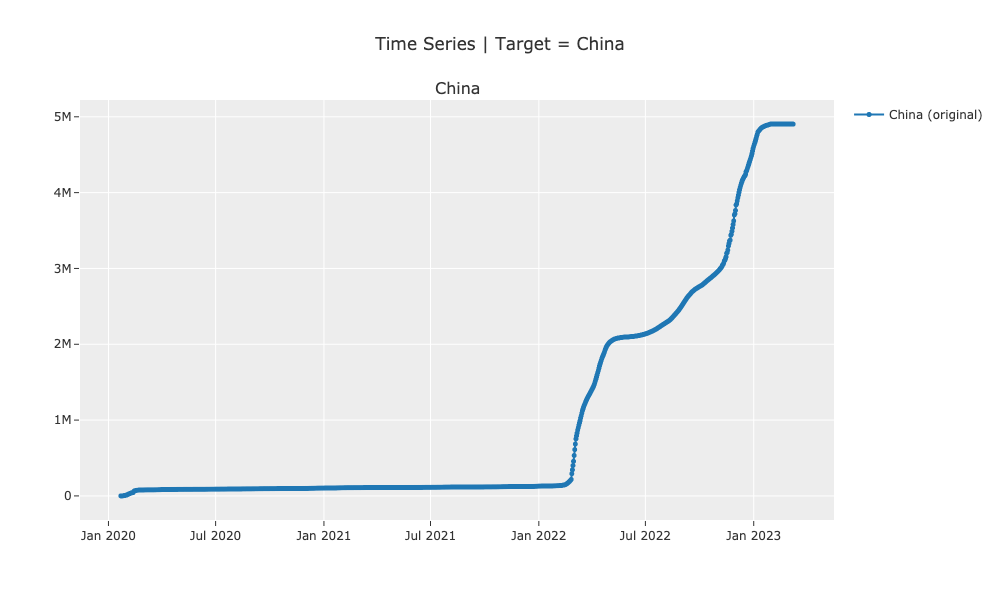

In [14]:
# NOTE: This is the same as `eda.plot_model(plot="ts")`
eda.plot_model()  

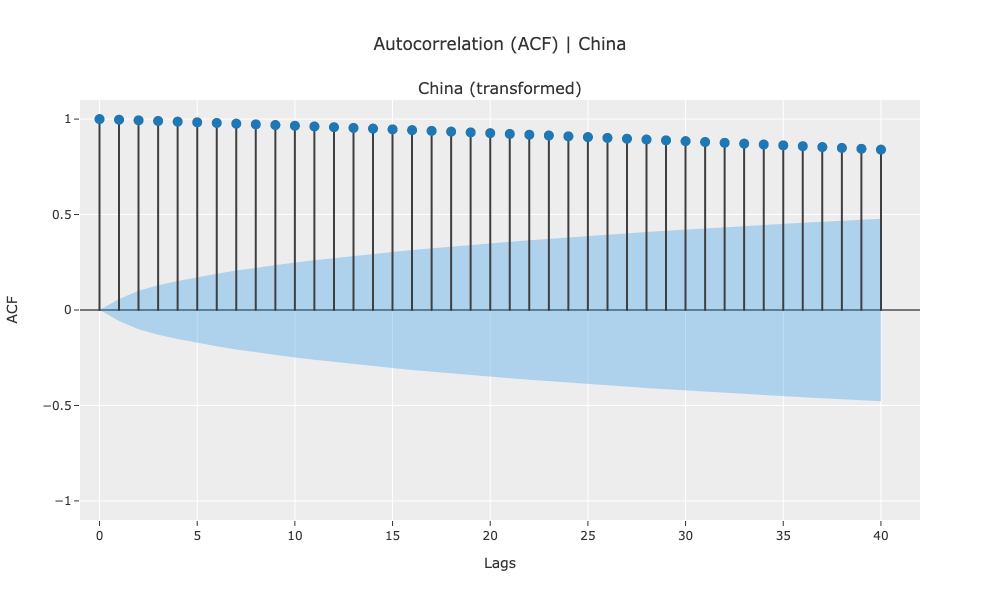

In [15]:
# ACF and PACF for the original dataset
eda.plot_model(plot="acf")

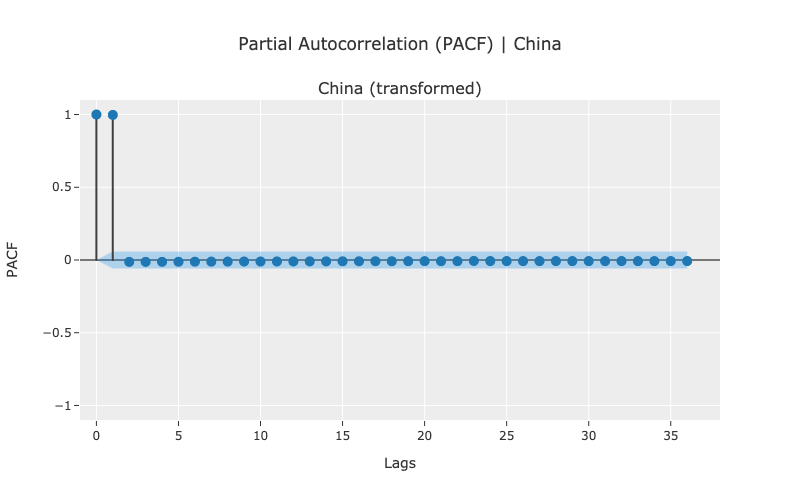

In [16]:
# NOTE: you can customize the plots with kwargs - e.g. number of lags, figure size (width, height), etc
# data_kwargs such as `nlags` are passed to the underlying function that gets the ACF values
# figure kwargs such as `fig_size` & `template` are passed to plotly and can have any value that plotly accepts
eda.plot_model(plot="pacf", data_kwargs={'nlags':36}, fig_kwargs={'height': 500, "width": 800})

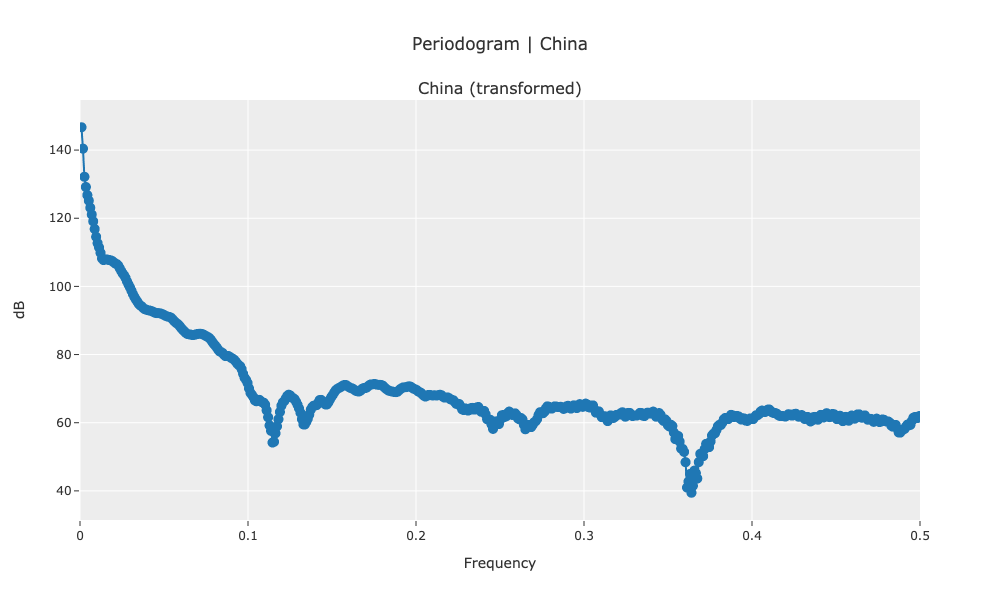

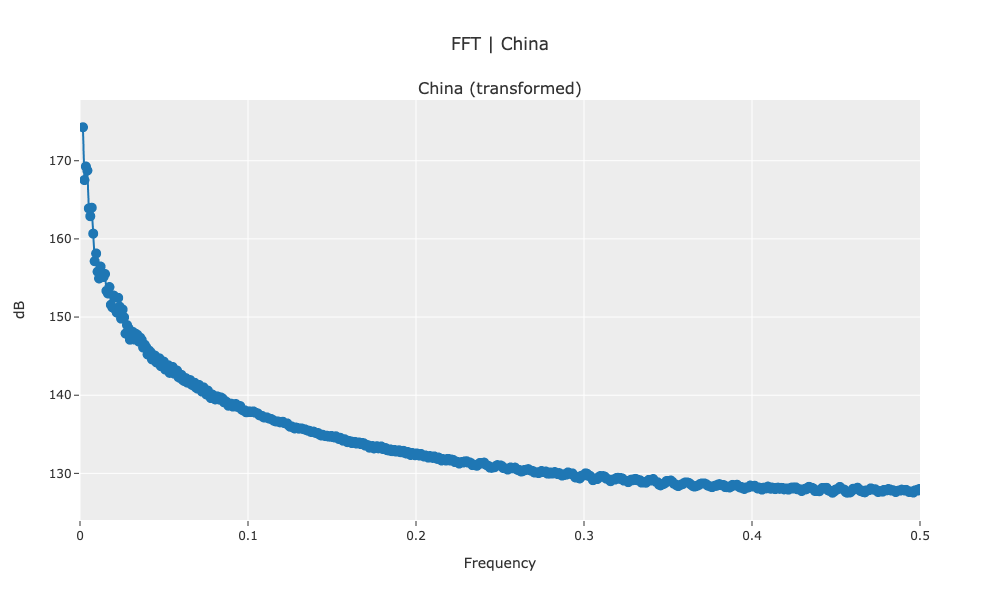

In [17]:
eda.plot_model(plot="periodogram")
eda.plot_model(plot="fft")

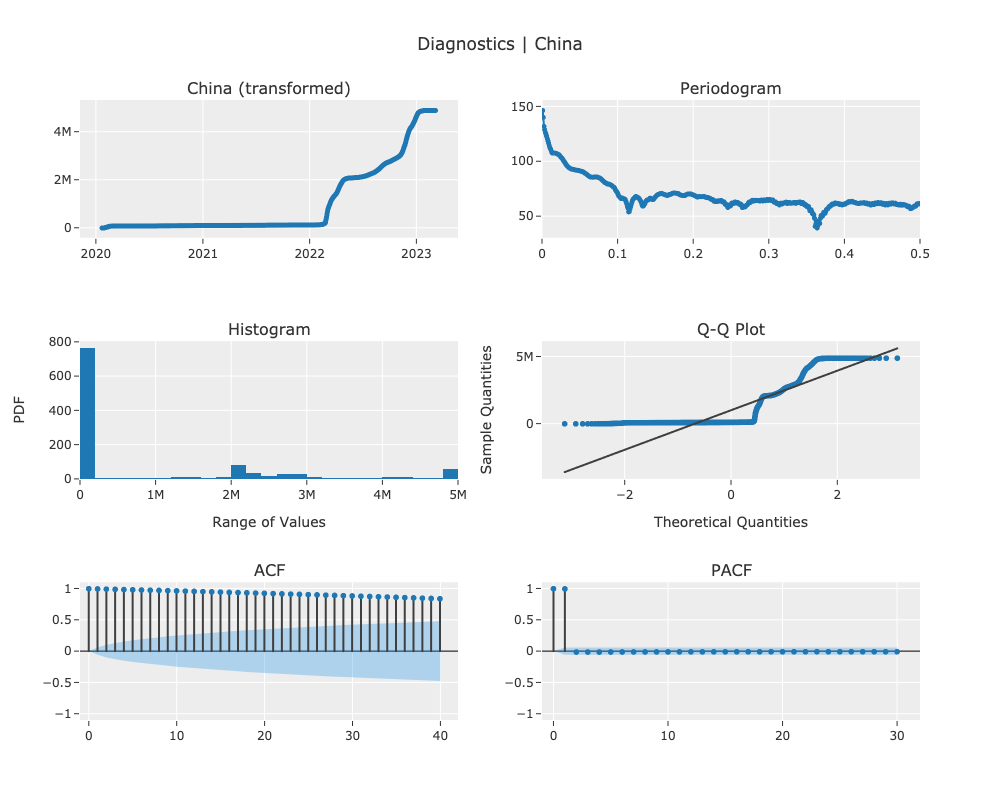

In [18]:
eda.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

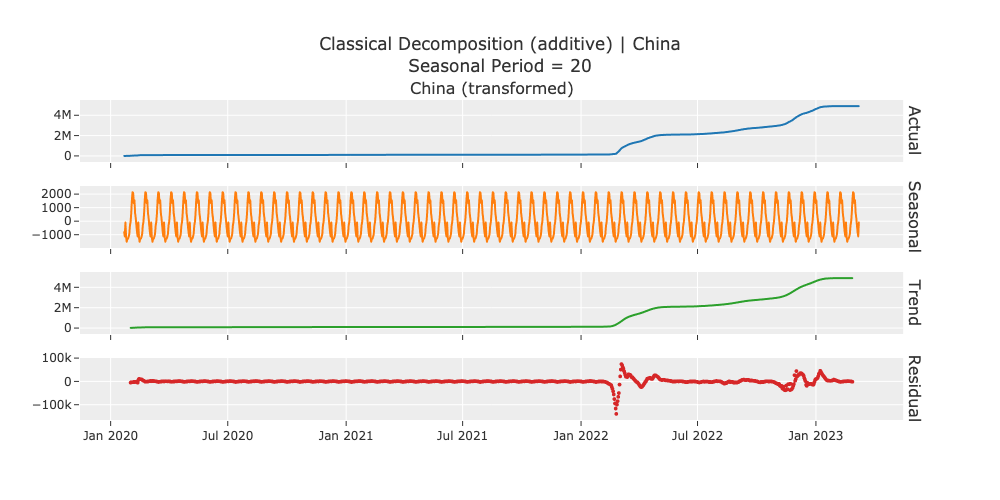

In [19]:
# First, classical decomposition
# By default the seasonal period is the one detected during setup - 12 in this case.
eda.plot_model(plot="decomp", fig_kwargs={"height": 500})

## Modeling and time consumption

In [20]:
import time

In [22]:
best_baseline_models

[NaiveForecaster(),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [20, 19,
                                                                         18, 17,
                                                                         16, 15,
                                                                         14, 13,
                                                                         12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=HuberRegressor(), sp=20, window_length=20),
 AutoETS(seasonal='mul', sp=20, trend='add')]

,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1123, 1)"
7,Transformed test set shape,"(20, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.9163,0.4534,77947.9486,90451.5762,0.0160,0.0156,-2588380.2905,127.2033
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.9259,0.4702,77494.3718,92934.3659,0.0160,0.0157,-202428.4975,0.0700
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.0417,0.5246,88883.5907,104800.0093,0.0182,0.0177,-6993333.4613,0.1300
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.0850,0.5474,91022.8191,108223.0273,0.0188,0.0185,-2934226.8887,0.5333
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0850,0.5474,91022.7997,108223.0060,0.0188,0.0185,-2934226.4617,0.0700
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.0850,0.5474,91022.8191,108223.0273,0.0188,0.0185,-2934226.8888,0.2000
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.0866,0.5481,91129.0831,108351.6935,0.0188,0.0185,-2904206.0692,0.0733
ets,ETS,1.1705,0.5775,97308.6535,113780.3598,0.0202,0.0199,-1193640.4549,0.3333
exp_smooth,Exponential Smoothing,1.1971,0.6668,99982.8790,132088.3730,0.0209,0.0207,-75294857.6226,0.0800
stlf,STLF,1.2340,0.6020,101586.5919,117349.5980,0.0213,0.0215,-52605532.4613,0.4133


Time taken for fh=20: 1005.5709271430969 seconds


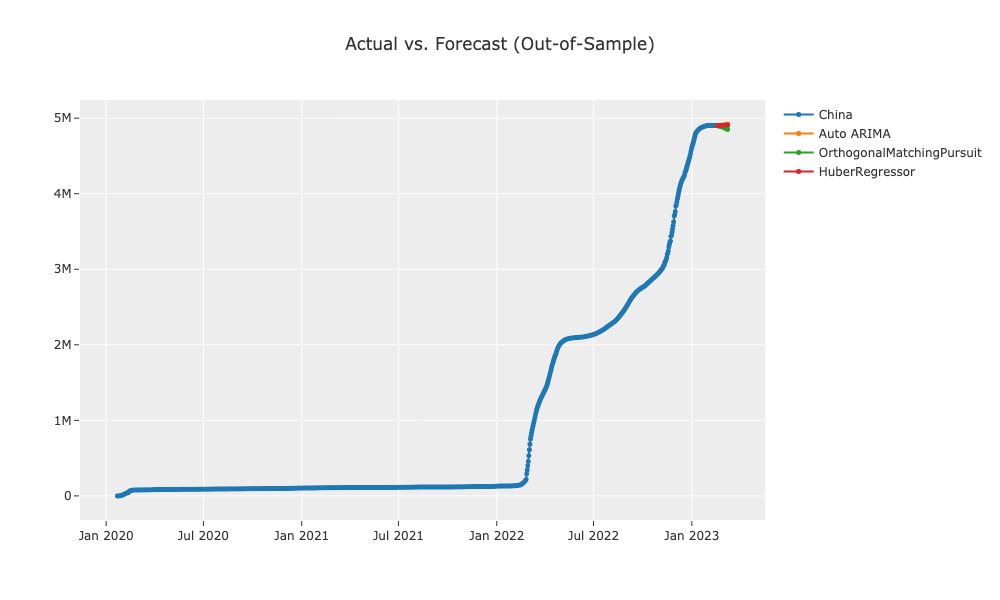

,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1134, 1)"
7,Transformed test set shape,"(9, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.0001,0.0000,5.7407,6.2539,0.0000,0.0000,-5.1044,0.6067
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0268,0.0140,2386.1950,2827.7393,0.0005,0.0005,-5357569.3374,0.0967
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0273,0.0142,2435.1658,2883.7225,0.0005,0.0005,-5420095.3087,0.1033
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0273,0.0142,2435.1649,2883.7214,0.0005,0.0005,-5420094.6777,0.0367
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0273,0.0142,2435.1658,2883.7225,0.0005,0.0005,-5420095.3113,0.1700
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.0387,0.0198,3451.7440,4013.0052,0.0007,0.0007,-7556044.6103,0.0400
ets,ETS,0.0695,0.0352,6184.4830,7130.0569,0.0013,0.0013,-33271582.1896,0.3300
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.0757,0.0378,6729.4856,7647.6677,0.0014,0.0014,-40571012.4583,0.0400
auto_arima,Auto ARIMA,0.0854,0.0487,7610.9159,9867.7828,0.0016,0.0016,-37760178.6739,144.9267
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.1326,0.0638,11792.5696,12891.0224,0.0024,0.0024,-131129069.5154,0.4767


Time taken for fh=9: 454.0758502483368 seconds


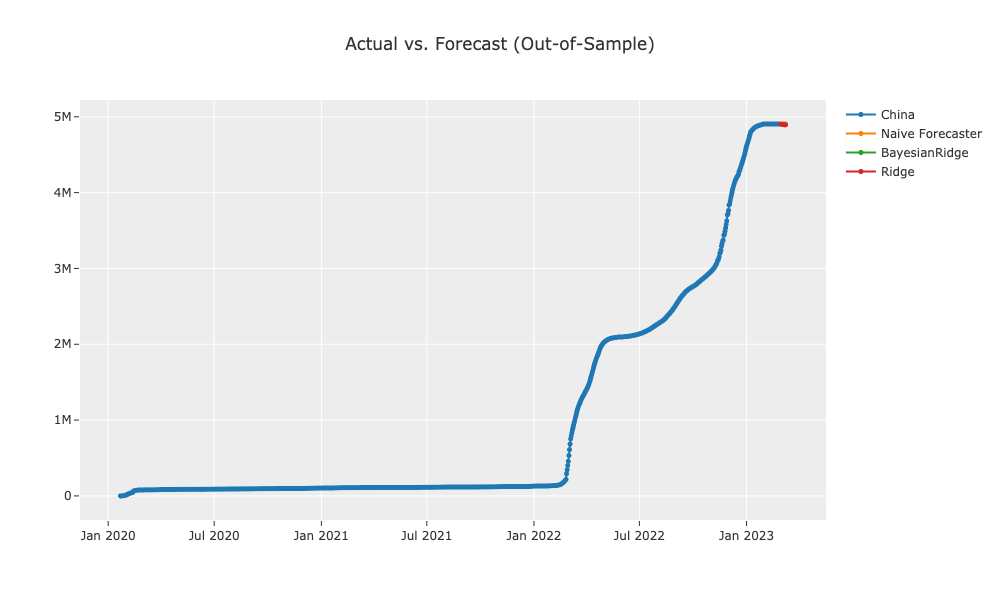

,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1132, 1)"
7,Transformed test set shape,"(11, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0213,0.0127,1905.8176,2589.4306,0.0004,0.0004,-195540.8059,0.5000
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0213,0.0127,1905.8176,2589.4306,0.0004,0.0004,-195540.8059,0.0467
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0213,0.0127,1905.8183,2589.4318,0.0004,0.0004,-195541.1821,0.0467
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0219,0.0131,1951.8300,2657.9171,0.0004,0.0004,-220034.1417,0.4700
naive,Naive Forecaster,0.0411,0.0193,3676.5152,3925.1549,0.0007,0.0008,-4.6467,0.0133
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.0654,0.0332,5844.2047,6741.4528,0.0012,0.0012,-3023106.7145,0.0500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.0965,0.0488,8602.1248,9903.2472,0.0018,0.0018,-27984114.2039,0.0467
auto_arima,Auto ARIMA,0.1354,0.0781,12103.5317,15879.9322,0.0025,0.0025,-15103309.4257,143.5033
ets,ETS,0.1512,0.0749,13476.0177,15189.5560,0.0027,0.0027,-53445727.9576,0.3233
theta,Theta Forecaster,0.1558,0.0777,13883.0289,15745.3626,0.0028,0.0028,-97875858.9577,0.5600


Time taken for fh=11: 446.04872584342957 seconds


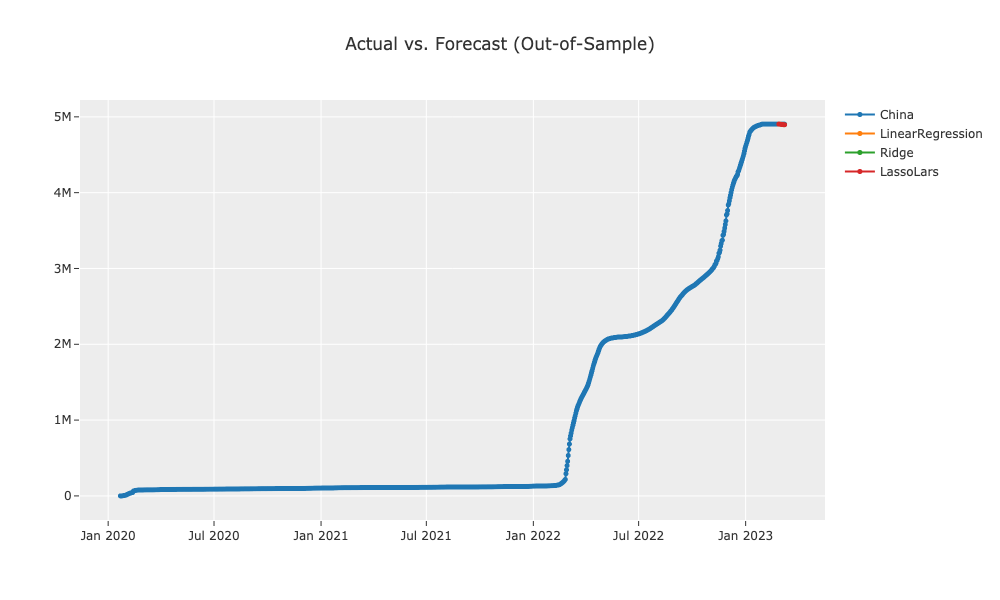

,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1130, 1)"
7,Transformed test set shape,"(13, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.0869,0.0415,7641.1538,8422.9762,0.0016,0.0016,-3.3811,0.0133
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.1163,0.0596,10402.2939,12126.3928,0.0021,0.0021,-6935634.9630,0.1100
ets,ETS,0.1348,0.0667,11959.9976,13521.5509,0.0024,0.0024,-31697726.6351,0.7233
theta,Theta Forecaster,0.1649,0.0860,14667.1417,17466.3877,0.0030,0.0030,-13338240.2519,0.3933
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.1862,0.0940,16620.9718,19070.4147,0.0034,0.0034,-61978431.0843,0.1133
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2010,0.0994,17910.3384,20179.6126,0.0037,0.0036,-46241407.5661,0.0833
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2022,0.0997,18030.5603,20228.0393,0.0037,0.0037,-60415148.9975,0.1467
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.2058,0.0988,18259.2071,20076.1689,0.0037,0.0037,-5924444.4756,0.0533
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.2069,0.0994,18363.7762,20186.3650,0.0037,0.0037,-6002350.6512,0.0500
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.2069,0.0994,18363.7736,20186.3624,0.0037,0.0037,-6002349.9419,0.1067


Time taken for fh=13: 441.39035511016846 seconds


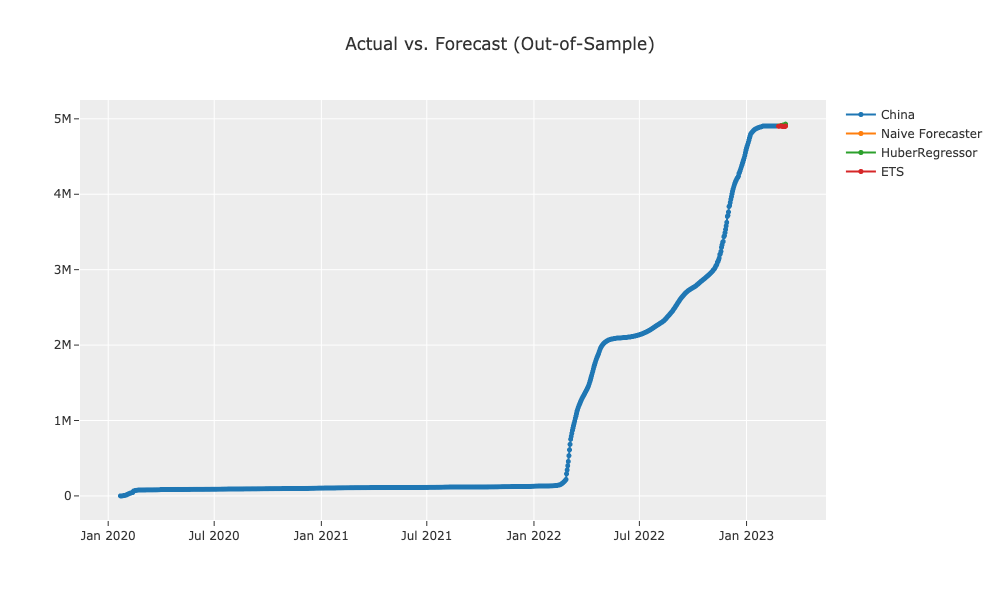

In [21]:
# List of forecast horizons
forecast_horizons = [20, 9, 11, 13]

for fh in forecast_horizons:
    # Record the start time for each iteration
    start_time = time.time()

    # Use 3 fold cross-validation to test the models.
    fold = 3

    fig_kwargs = {
        "renderer": "png",
        "width": 1000,
        "height": 600,
    }

    exp = TSForecastingExperiment()
    exp.setup(data=df_confirmed_subset, fh=fh, fold=fold, fig_kwargs=fig_kwargs, session_id=42)

    best_baseline_models = exp.compare_models(n_select=3)

    # Record the end time for each iteration
    end_time = time.time()

    # Calculate the elapsed time for each iteration
    elapsed_time = end_time - start_time

    # Print the elapsed time for each iteration
    print(f"Time taken for fh={fh}: {elapsed_time} seconds")
    
    exp.plot_model(best_baseline_models)


,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1083, 1)"
7,Transformed test set shape,"(60, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,2.9559,1.2536,162416.1062,193392.5758,0.0480,0.0487,-0.0849,78.6767
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.8290,1.6442,208985.3520,253445.9790,0.0643,0.0623,-3.6958,0.1833
ets,ETS,4.2750,1.8338,239030.1550,282687.1579,0.0669,0.0689,-0.9039,0.8267
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,5.0370,2.2428,279605.6980,346167.6435,0.0780,0.0848,-0.9923,0.3133
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,5.0370,2.2428,279605.6980,346167.6436,0.0780,0.0848,-0.9923,0.2367
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,5.0370,2.2428,279605.7065,346167.6581,0.0780,0.0848,-0.9923,0.2367
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,5.0442,2.2459,280026.2609,346652.1018,0.0781,0.0850,-0.9950,0.2033
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,5.0889,2.2043,289904.8376,339758.3915,0.0754,0.0824,-0.1867,0.2433
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,5.0889,2.2043,289904.8376,339758.3915,0.0754,0.0824,-0.1867,0.2400
arima,ARIMA,5.3427,2.2874,301100.3573,352678.6867,0.0815,0.0876,-0.6516,0.0333


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-12,1.6163,0.6780,77856.1653,105430.2133,0.0316,0.0325,0.3238
1,2022-09-10,2.6822,1.0868,141729.3053,167408.4326,0.0491,0.0475,-1.2700
2,2022-11-09,4.5155,1.9702,264448.8937,303374.6617,0.0627,0.0653,0.6696
Mean,NaT,2.9380,1.2450,161344.7881,192071.1025,0.0478,0.0485,-0.0922
SD,NaT,1.1974,0.5393,77428.6207,82670.7793,0.0127,0.0134,0.8447


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.8min finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-12,1.7349,0.7106,83571.3038,110499.3532,0.0340,0.0350,0.2572
1,2022-09-10,2.7789,1.0999,146840.2100,169429.2792,0.0509,0.0493,-1.3251
2,2022-11-09,7.0007,3.0726,409988.8882,473124.0852,0.0968,0.1032,0.1965
Mean,NaT,3.8382,1.6277,213466.8007,251017.5725,0.0606,0.0625,-0.2905
SD,NaT,2.2765,1.0340,141342.2248,158884.9925,0.0265,0.0293,0.7320


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-12,1.1249,0.5131,54188.4555,79788.7161,0.0219,0.0224,0.6127
1,2022-09-10,3.2324,1.3301,170800.2675,204900.0047,0.0590,0.0567,-2.4006
2,2022-11-09,5.0952,2.2101,298394.1511,340320.9200,0.0709,0.0742,0.5843
Mean,NaT,3.1508,1.3511,174460.9580,208336.5469,0.0506,0.0511,-0.4012
SD,NaT,1.6219,0.6930,99730.1557,106389.5818,0.0209,0.0215,1.4138


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-12,1.2389,0.5407,59679.6720,84080.6892,0.0241,0.0247,0.5699
1,2022-09-10,4.0128,1.6855,212041.4378,259636.9672,0.0731,0.0695,-4.4602
2,2022-11-09,4.6418,2.0015,271841.8182,308193.8998,0.0649,0.0676,0.6590
Mean,NaT,3.2979,1.4092,181187.6427,217303.8521,0.0541,0.0539,-1.0771
SD,NaT,1.4783,0.6275,89320.2537,96266.1320,0.0214,0.0207,2.3925


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,8.9960,4.5595,765286.0129,910060.9548,0.1561,0.1408,-1541.2481


Time taken for fh=60: 11161.268598794937 seconds


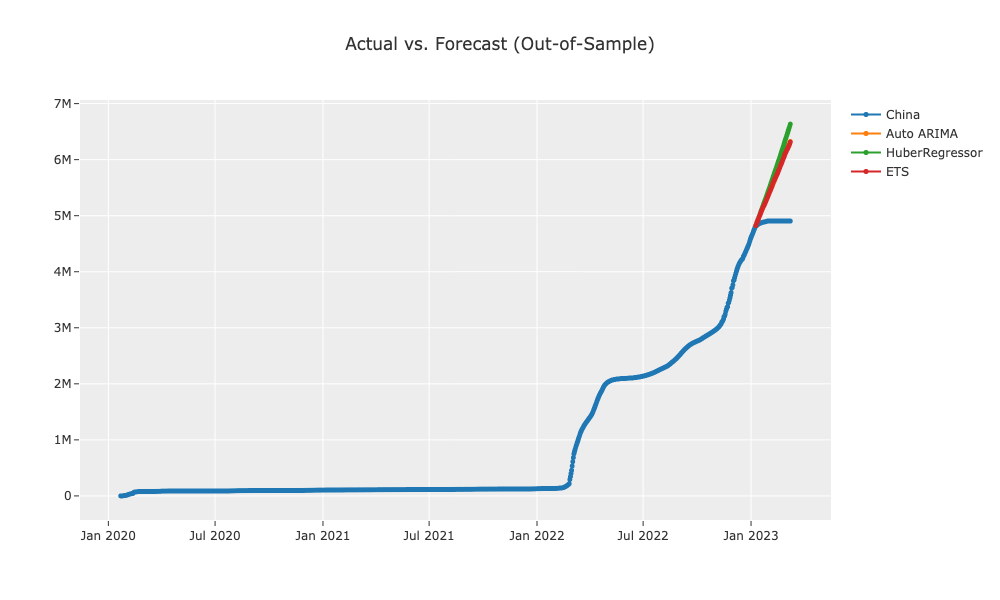

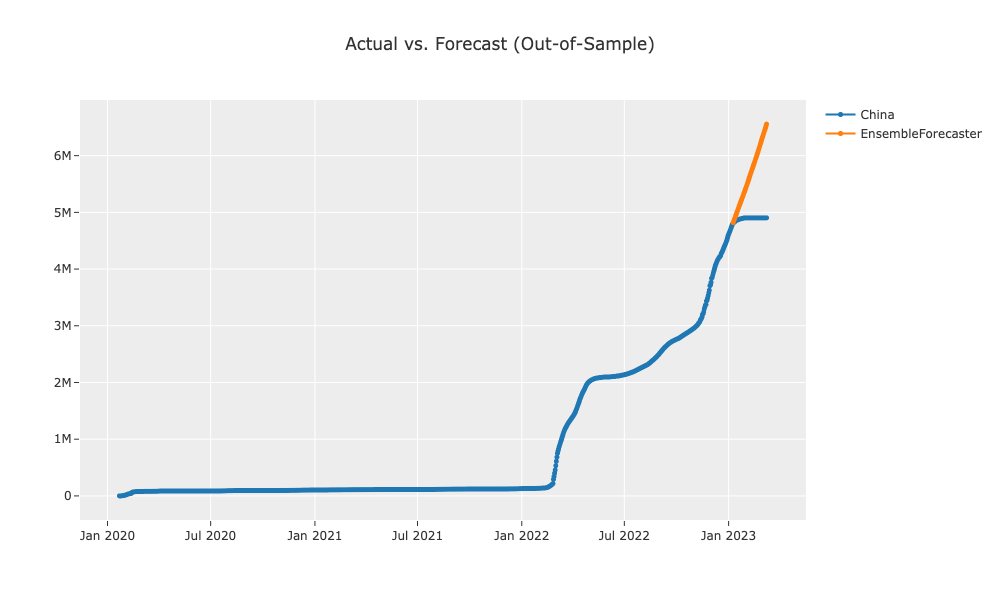

                  y_pred
2023-01-09  4.818800e+06
2023-01-10  4.844719e+06
2023-01-11  4.873735e+06
2023-01-12  4.897310e+06
2023-01-13  4.924447e+06
2023-01-14  4.951754e+06
2023-01-15  4.980905e+06
2023-01-16  5.008049e+06
2023-01-17  5.036477e+06
2023-01-18  5.065703e+06
2023-01-19  5.094324e+06
2023-01-20  5.121776e+06
2023-01-21  5.147436e+06
2023-01-22  5.175744e+06
2023-01-23  5.200575e+06
2023-01-24  5.227599e+06
2023-01-25  5.254274e+06
2023-01-26  5.280395e+06
2023-01-27  5.307089e+06
2023-01-28  5.338345e+06
2023-01-29  5.362389e+06
2023-01-30  5.389834e+06
2023-01-31  5.420545e+06
2023-02-01  5.446672e+06
2023-02-02  5.475780e+06
2023-02-03  5.505214e+06
2023-02-04  5.536327e+06
2023-02-05  5.565651e+06
2023-02-06  5.595912e+06
2023-02-07  5.627632e+06
2023-02-08  5.658656e+06
2023-02-09  5.688571e+06
2023-02-10  5.716461e+06
2023-02-11  5.747017e+06
2023-02-12  5.774257e+06
2023-02-13  5.803610e+06
2023-02-14  5.832850e+06
2023-02-15  5.861677e+06
2023-02-16  5.890651e+06


In [26]:
# List of forecast horizons
forecast_horizons = [60]

for fh in forecast_horizons:
    # Record the start time for each iteration
    start_time = time.time()

    # Use 3 fold cross-validation to test the models.
    fold = 3

    fig_kwargs = {
        "renderer": "png",
        "width": 1000,
        "height": 600,
    }

    exp = TSForecastingExperiment()
    exp.setup(data=df_confirmed_subset, fh=fh, fold=fold, fig_kwargs=fig_kwargs, session_id=42)

    best_baseline_models = exp.compare_models(n_select=3)

    best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]

    blender = exp.blend_models(best_tuned_models, method='mean')
    y_predict = exp.predict_model(blender)

    # Record the end time for each iteration
    end_time = time.time()

    # Calculate the elapsed time for each iteration
    elapsed_time = end_time - start_time

    # Print the elapsed time for each iteration
    print(f"Time taken for fh={fh}: {elapsed_time} seconds")
    
    exp.plot_model(best_baseline_models)

    exp.plot_model(estimator=blender)
    print(y_predict)

,Description,Value
0,session_id,42
1,Target,China
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1143, 1)"
5,Transformed data shape,"(1143, 1)"
6,Transformed train set shape,"(1136, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.0000,0.0000,1.4286,1.7546,0.0000,0.0000,-3.1717,0.7600
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.0182,0.0087,1619.2962,1758.8360,0.0003,0.0003,-3853329.2339,0.0367
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0211,0.0105,1882.5399,2131.8984,0.0004,0.0004,-5481979.8246,0.1067
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0212,0.0106,1891.9269,2142.5180,0.0004,0.0004,-5500339.3281,0.1133
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0212,0.0106,1891.9262,2142.5176,0.0004,0.0004,-5500338.3022,0.0333
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0212,0.0106,1891.9269,2142.5180,0.0004,0.0004,-5500339.3288,0.1833
auto_arima,Auto ARIMA,0.0288,0.0163,2557.2197,3294.6022,0.0005,0.0005,-13935523.6365,145.8133
snaive,Seasonal Naive Forecaster,0.0532,0.0259,4740.4286,5243.4895,0.0010,0.0010,-32039005.5581,0.4433
arima,ARIMA,0.0679,0.0318,6045.4671,6434.3956,0.0012,0.0012,-33926508.4807,0.0433
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.0692,0.0353,6142.2286,7119.4633,0.0013,0.0013,-100552622.9590,0.0333


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-02-09,0.0000,0.0000,1.7143,2.2678,0.0000,0.0000,-1.3333
1,2023-02-16,0.0000,0.0000,1.7143,2.0702,0.0000,0.0000,-2.1818
2,2023-02-23,0.0000,0.0000,0.8571,0.9258,0.0000,0.0000,-6.0000
Mean,NaT,0.0000,0.0000,1.4286,1.7546,0.0000,0.0000,-3.1717
SD,NaT,0.0000,0.0000,0.4041,0.5916,0.0000,0.0000,2.0297


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-02-09,0.0207,0.0096,1849.2501,1942.6036,0.0004,0.0004,-1712144.7184
1,2023-02-16,0.0321,0.0199,2847.8819,4026.3123,0.0006,0.0006,-12035579.8646
2,2023-02-23,0.0069,0.0038,604.7218,766.3701,0.0001,0.0001,-4796470.7760
Mean,NaT,0.0199,0.0111,1767.2846,2245.0953,0.0004,0.0004,-6181398.4530
SD,NaT,0.0103,0.0067,917.5985,1347.9445,0.0002,0.0002,4326803.8094


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-02-09,0.0176,0.0095,1573.4313,1927.0496,0.0003,0.0003,-1684836.8183
1,2023-02-16,0.0459,0.0283,4073.4903,5710.6859,0.0008,0.0008,-24211889.0420
2,2023-02-23,0.0434,0.0232,3827.0949,4660.8443,0.0008,0.0008,-177408337.2858
Mean,NaT,0.0357,0.0203,3158.0055,4099.5266,0.0006,0.0006,-67768354.3821
SD,NaT,0.0128,0.0079,1124.9694,1594.8426,0.0002,0.0002,78070743.1707


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-02-09,0.0262,0.0127,2340.8967,2566.2723,0.0005,0.0005,-2987979.6991
1,2023-02-16,0.0071,0.0034,625.6131,680.6454,0.0001,0.0001,-343947.8938
2,2023-02-23,0.0048,0.0025,426.7072,497.8923,0.0001,0.0001,-2024488.6580
Mean,NaT,0.0127,0.0062,1131.0723,1248.2700,0.0002,0.0002,-1785472.0837
SD,NaT,0.0096,0.0046,859.3203,934.9500,0.0002,0.0002,1092572.7249


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.0059,0.0038,519.0258,769.7669,0.0001,0.0001,0.0000


Time taken for fh=60: 469.63064217567444 seconds


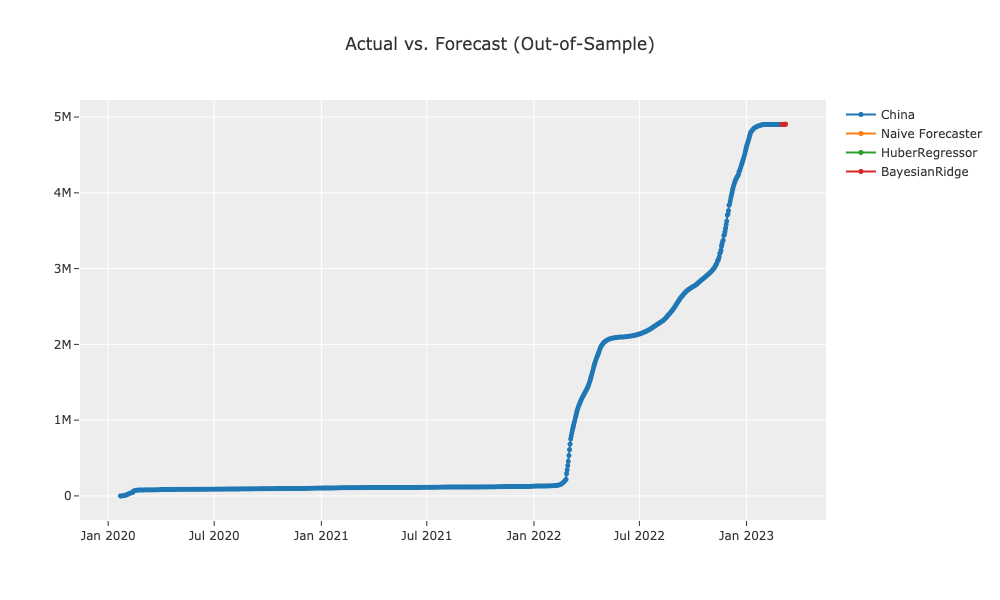

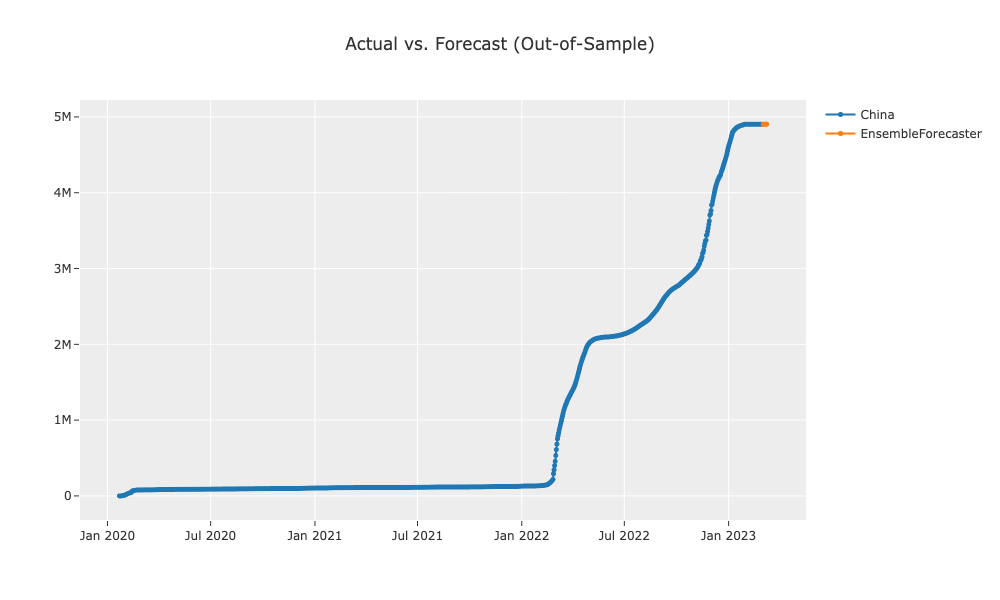

ValueError: DataFrame constructor not properly called!

In [53]:
# Record the start time for each iteration
start_time = time.time()

# Use 3 fold cross-validation to test the models.
fold = 3

fig_kwargs = {
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

exp = TSForecastingExperiment()
exp.setup(data=df_confirmed_subset, fh=7, fold=fold, fig_kwargs=fig_kwargs, session_id=42)

best_baseline_models = exp.compare_models(n_select=3)

best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]

blender = exp.blend_models(best_tuned_models, method='mean')
y_predict = exp.predict_model(blender)

# Record the end time for each iteration
end_time = time.time()

# Calculate the elapsed time for each iteration
elapsed_time = end_time - start_time

# Print the elapsed time for each iteration
print(f"Time taken for fh={fh}: {elapsed_time} seconds")

exp.plot_model(best_baseline_models)

exp.plot_model(estimator=blender)
pd.DataFrame(exp).to_csv("results/model_results.csv",index=False)
print(y_predict)

In [58]:
help(compare_models)

Help on function compare_models in module pycaret.time_series.forecasting.functional:

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Union[int, Any, NoneType] = None, round: int = 4, cross_validation: bool = True, sort: str = 'MASE', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, engine: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[pycaret.internal.parallel.parallel_backend.ParallelBackend] = None)
    This function trains and evaluates performance of all estimators available in the
    model library using cross validation. The output of this function is a score grid
    with average cross validated scores. Metrics evaluated during CV can be accessed
    using the ``get_metrics`` function. Custom metrics can be added or removed using
    ``add_metric`` and ``remove_metric`` function.
    
    
    Example
    -

In [56]:
best_baseline_models

[NaiveForecaster(),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [20, 19,
                                                                         18, 17,
                                                                         16, 15,
                                                                         14, 13,
                                                                         12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=HuberRegressor(), sp=20, window_length=20),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [20, 19,
                              

# Autoformer - Transformer

In [138]:
!pip install -q transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm
!pip install -q protobuf --upgrade # without it, the evaluation code fails

In [28]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
configuration = AutoformerConfig(prediction_length=60)

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [29]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = AutoformerModel.from_pretrained("huggingface/autoformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

In [31]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerForPrediction

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

In [32]:
batch["future_values"].size()

torch.Size([64, 24])

In [44]:
model = AutoformerForPrediction.from_pretrained(PRETRAINED_MODEL_NAME)

ValueError: Parameter config in `AutoformerForPrediction(config)` should be an instance of class `PretrainedConfig`. To create a model from a pretrained model use `model = AutoformerForPrediction.from_pretrained(PRETRAINED_MODEL_NAME)`

In [34]:
# during training, one provides both past and future values
# as well as possible additional features
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_time_features=batch["future_time_features"],
)

In [35]:
outputs.sequences.size()

torch.Size([64, 100, 24])

In [36]:
outputs

SampleTSPredictionOutput(sequences=tensor([[[19027.5625, 29934.0938, 26353.9434,  ..., 29666.5762,
          33380.5469, 31021.1289],
         [25216.8926, 40190.1992, 17759.1562,  ..., 31673.5078,
          34102.3164, 23420.6641],
         [26416.6543, 22683.3047, 26104.4941,  ..., 21872.6191,
          39907.3320, 32472.4004],
         ...,
         [29933.4023, 14914.6660, 28916.7188,  ..., 25883.7871,
          39701.0352, 32814.5117],
         [20567.9648, 30896.8027, 26141.6855,  ..., 40722.1680,
          34732.1914, 35366.2383],
         [20844.8066, 17981.8047, 25143.0098,  ..., 37916.0469,
          38652.9688, 24801.5879]],

        [[12576.0967, 39880.2461, 41246.7578,  ..., 23349.3438,
          20609.7422, 27002.5098],
         [25713.0898, 35090.7344, 54328.8516,  ..., 16082.2480,
          24880.2070, 10054.0342],
         [20922.9688, 30783.2715, 43524.8086,  ...,  3891.1582,
          18203.9043, 25871.3320],
         ...,
         [32066.1113, 35990.4453, 54805.0625

In [37]:
values = batch["future_values"].tolist()

In [38]:
preds = outputs.sequences.mean(dim=1).tolist()

In [39]:
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
mdase = MedianAbsoluteScaledError()

In [42]:
series_mape = []
series_mase = []
for i in range(len(values)):
    series_mape.append(mape(y_true=pd.Series(values[i]),y_pred=pd.Series(preds[i])))
    series_mase.append(mase(y_true=pd.Series(values[i]),y_pred=pd.Series(preds[i]),y_train=pd.Series(batch["past_values"].tolist()[i])))

In [52]:
import exp
from exp.exp_main import Exp_Main

ModuleNotFoundError: No module named 'exp.exp_main'

In [49]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np


def main():
    fix_seed = 2021
    random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)

    parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

    # basic config
    parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
    parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
    parser.add_argument('--model', type=str, required=True, default='Autoformer',
                        help='model name, options: [Autoformer, Informer, Transformer]')

    # data loader
    parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
    parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
    parser.add_argument('--features', type=str, default='M',
                        help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
    parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
    parser.add_argument('--freq', type=str, default='h',
                        help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

    # forecasting task
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--label_len', type=int, default=48, help='start token length')
    parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')

    # model define
    parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')
    parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')
    parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
    parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
    parser.add_argument('--c_out', type=int, default=7, help='output size')
    parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
    parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
    parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
    parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
    parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
    parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
    parser.add_argument('--factor', type=int, default=1, help='attn factor')
    parser.add_argument('--distil', action='store_false',
                        help='whether to use distilling in encoder, using this argument means not using distilling',
                        default=True)
    parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
    parser.add_argument('--embed', type=str, default='timeF',
                        help='time features encoding, options:[timeF, fixed, learned]')
    parser.add_argument('--activation', type=str, default='gelu', help='activation')
    parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
    parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

    # optimization
    parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
    parser.add_argument('--itr', type=int, default=2, help='experiments times')
    parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
    parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
    parser.add_argument('--des', type=str, default='test', help='exp description')
    parser.add_argument('--loss', type=str, default='mse', help='loss function')
    parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
    parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

    # GPU
    parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
    parser.add_argument('--gpu', type=int, default=0, help='gpu')
    parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
    parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

    args = parser.parse_args()

    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

    print('Args in experiment:')
    print(args)

    Exp = Exp_Main

    if args.is_training:
        for ii in range(args.itr):
            # setting record of experiments
            setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
                args.model_id,
                args.model,
                args.data,
                args.features,
                args.seq_len,
                args.label_len,
                args.pred_len,
                args.d_model,
                args.n_heads,
                args.e_layers,
                args.d_layers,
                args.d_ff,
                args.factor,
                args.embed,
                args.distil,
                args.des, ii)

            exp = Exp(args)  # set experiments
            print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
            exp.train(setting)

            print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.test(setting)

            if args.do_predict:
                print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
                exp.predict(setting, True)

            torch.cuda.empty_cache()
    else:
        ii = 0
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.model_id,
                                                                                                      args.model,
                                                                                                      args.data,
                                                                                                      args.features,
                                                                                                      args.seq_len,
                                                                                                      args.label_len,
                                                                                                      args.pred_len,
                                                                                                      args.d_model,
                                                                                                      args.n_heads,
                                                                                                      args.e_layers,
                                                                                                      args.d_layers,
                                                                                                      args.d_ff,
                                                                                                      args.factor,
                                                                                                      args.embed,
                                                                                                      args.distil,
                                                                                                      args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting, test=1)
        torch.cuda.empty_cache()


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'exp.exp_main'

In [46]:
import os

# args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

NameError: name 'args' is not defined